# Exploratory Data Analysis on the Preprocessed (Dr. Su) Medicare Transactions Dataset

In [1]:
# hook Google Drive up
from google.colab import drive
drive.mount('/content/drive')
# import libraries and set the random seed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1)
# load data and fix the categorical data types
project_dir = './drive/My Drive/Colab Notebooks/medicare/NSF-Medicare/'
data_dir = project_dir + 'datasets/combi_catego_numeri_features.csv'
data = pd.read_csv(data_dir)
data['state_type'] = data['state_type'].astype('category') # for type consistency
data['label'] = data['label'].astype('category') # for type consistency
data['provider_type'] = data['provider_type'].astype('category') # for type consistency
data['state'] = data['state'].astype('category') # for type consistency
data['gender'] = data['gender'].astype('category') # for type consistency

%matplotlib inline
plt.style.use('bmh')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data.head() # have a glance at some of the records.

In [2]:
data.info() # this is good to see how many null records exist for each column. also, data type distribution for columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937311 entries, 0 to 937310
Data columns (total 18 columns):
NPI                                937311 non-null int64
gender                             937311 non-null category
state                              937311 non-null category
provider_type                      937311 non-null category
state_type                         937311 non-null category
tot_num_ser                        937311 non-null float64
tot_num_benefi                     937311 non-null float64
tot_num_disti_benefi_ser           937311 non-null float64
num_benefi_and_num_ser_ratio       937311 non-null float64
num_disti_ser_and_num_ser_ratio    937311 non-null float64
tot_num_HCPCS_code                 937311 non-null int64
num_ser_O                          937311 non-null float64
num_ser_F                          937311 non-null float64
cos_simi_no_type                   937311 non-null float64
cos_simi_focus_type                937311 non-null float64
comp

**A list of things to notice are:**
1. Features have different scales, will need normalization before any model training.
2. Dataset is a mixture of categorical and numerical features.
3. For our analysis, NPI  is not useful since it is a unique ID for each record.
4. We don't have null records.

In [0]:
del data['NPI'] # get rid of NPI column

**Lets define a function to summarize and plot the distribution statistics of a feature.**

count    937311.000000
mean          6.223061
std           1.631406
min           1.386294
25%           5.123964
50%           6.269096
75%           7.346010
max          16.309286
Name: tot_num_ser, dtype: float64


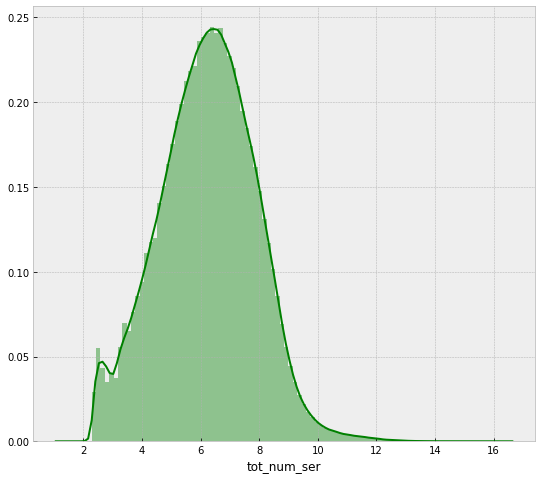

In [4]:
def get_feature_stats(dataset, feature_name, log_transform=False):
  feature = dataset[feature_name]
  if log_transform: # certain features are heavy tailed, log transform helps
    feature = feature.apply(np.log)
  print(feature.describe())
  plt.figure(figsize=(9, 8))
  return sns.distplot(feature, color='g', bins=100, hist_kws={'alpha': 0.4})

# e.g.
get_feature_stats(data, 'tot_num_ser', log_transform=True)

**Now lets separate numerical and categorical values to inspect them individually.**

In [5]:
data_num = data.select_dtypes(include = ['float64', 'int64'])
data_num.head()

,tot_num_ser,tot_num_benefi,tot_num_disti_benefi_ser,num_benefi_and_num_ser_ratio,num_disti_ser_and_num_ser_ratio,tot_num_HCPCS_code,num_ser_O,num_ser_F,cos_simi_no_type,cos_simi_focus_type,compa_ser_vs_aver_no_type,compa_ser_vs_aver_focus_type
0,2728.0,1748.0,2728.0,0.640762,1.000000,8,2728.0,0.0,0.951048,0.980605,1.000000,1.0
1,8624.0,5339.0,6388.0,0.619086,0.740724,9,8624.0,0.0,0.256817,0.975313,1.000000,1.0
2,482.0,309.0,481.0,0.641079,0.997925,9,120.0,362.0,0.705476,0.832820,0.888889,1.0
3,918.0,695.0,918.0,0.757081,1.000000,18,918.0,0.0,0.791392,0.672591,1.000000,1.0
4,55.0,52.0,55.0,0.945455,1.000000,3,0.0,55.0,0.533957,0.998392,0.666667,0.0


**Plot the distribution of all numerical features.**

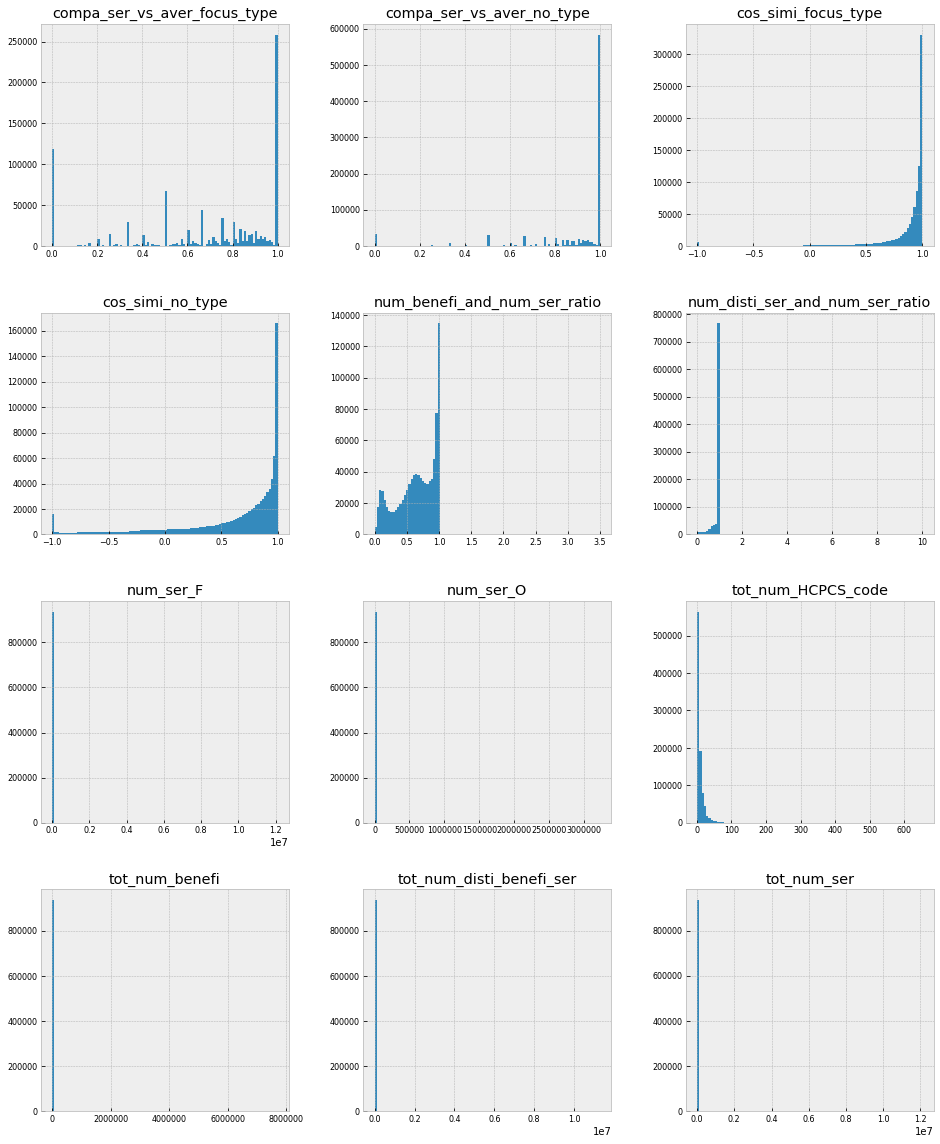

In [6]:
data_num.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

**Observations:**
It seems like we can use log-transform (or inverse hyperbolic sine to prevent 0 going to -inf) on extremely heavy tailed distributions.

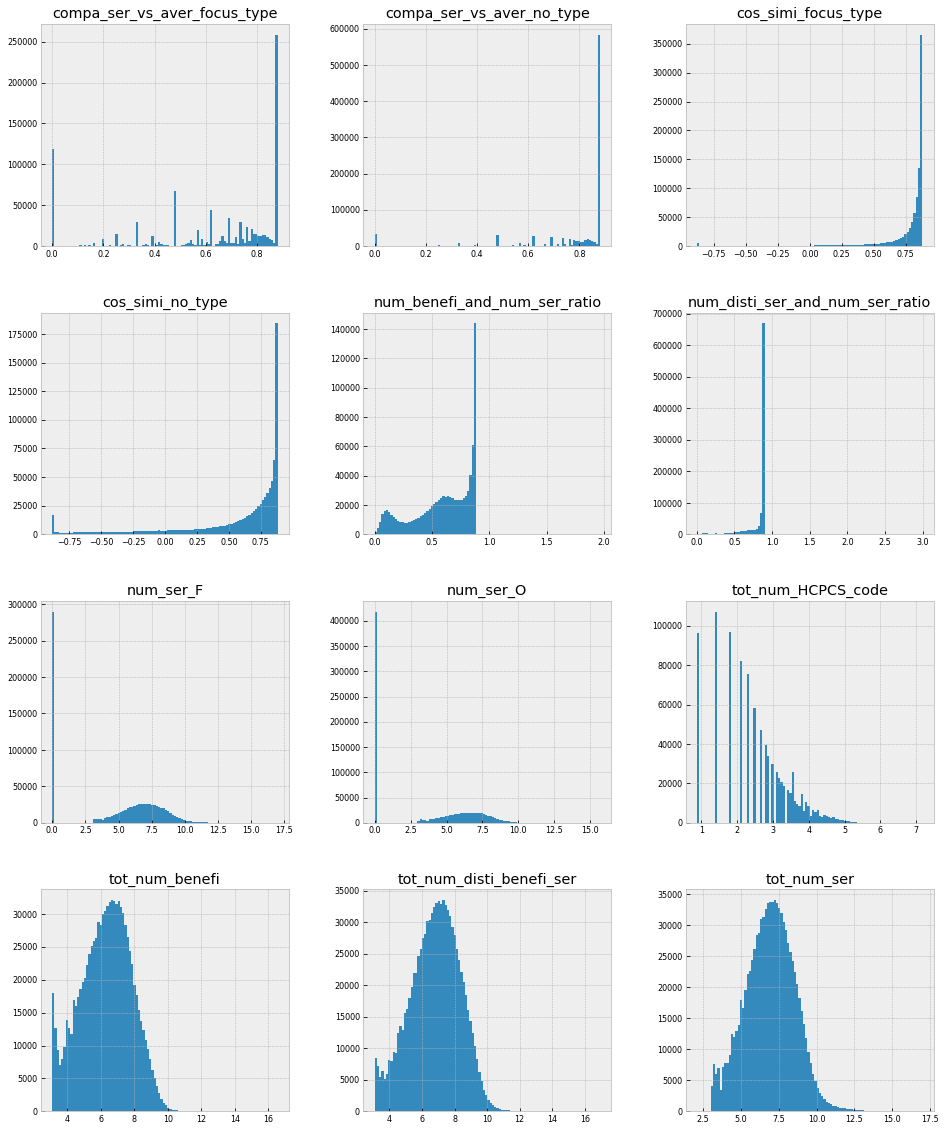

In [7]:
data_num.apply(np.arcsinh).hist(figsize=(16,20), bins=100, xlabelsize=8, ylabelsize=8);

**Observation:** Even after the transformation, we see that some features have outliers. Removing the outliers can support the correlation between the corresponding feature and the class label.

# Feature-Label Correlations
Lets compare feature-label correlations between **original**, **transformed** and **transformed + outlier removed** versions of the dataset.

**Again note that:**
1. Log transform may help with linear correlation.
2. Outliers weaken the correlation between variables.

In [8]:
# remove outliers
from scipy import stats
no_outlier = data_num[(np.abs(stats.zscore(data_num)) < 3).all(axis=1)]
transformed = data_num.apply(np.arcsinh)
no_outlier_trans = transformed[(np.abs(stats.zscore(transformed)) < 3).all(axis=1)]
original = data_num

no_outlier['label'] = data['label'].cat.codes
transformed['label'] = data['label'].cat.codes
no_outlier_trans['label'] = data['label'].cat.codes
original['label'] = data['label'].cat.codes

org = original.corr()['label']
org = org.rename('original')
no_out = no_outlier.corr()['label']
no_out = no_out.rename('no outlier')
tr = transformed.corr()['label']
tr = tr.rename('transformed')
no_out_tr = no_outlier_trans.corr()['label']
no_out_tr = no_out_tr.rename('no out transformed')
pd.concat([org, no_out, tr, no_out_tr], axis=1).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,index,original,no outlier,transformed,no out transformed
0,tot_num_ser,0.004959,0.014632,0.009401,0.008455
1,tot_num_benefi,0.000661,0.006242,0.004377,0.002627
2,tot_num_disti_benefi_ser,0.001722,0.015296,0.010211,0.008865
3,num_benefi_and_num_ser_ratio,-0.015072,-0.015164,-0.014829,-0.015035
4,num_disti_ser_and_num_ser_ratio,0.000029,0.000871,0.000087,0.000999
5,tot_num_HCPCS_code,0.003753,0.003787,0.003476,0.001661
6,num_ser_O,-0.000871,-0.003441,-0.011674,-0.010726
7,num_ser_F,0.005350,0.016890,0.015435,0.014011
8,cos_simi_no_type,-0.002088,-0.001186,-0.002041,-0.000836
9,cos_simi_focus_type,-0.012812,-0.011568,-0.012712,-0.011944


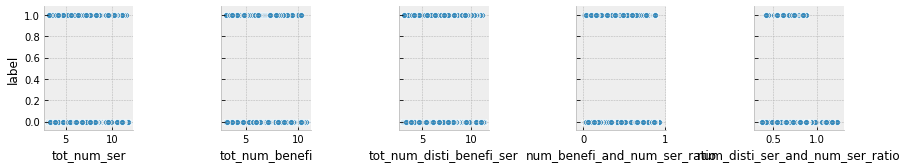

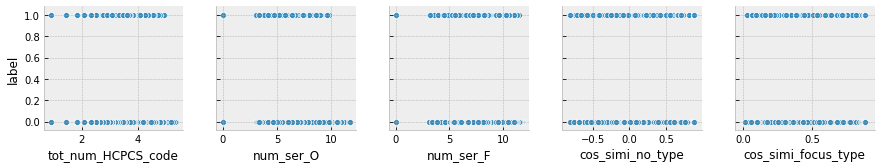

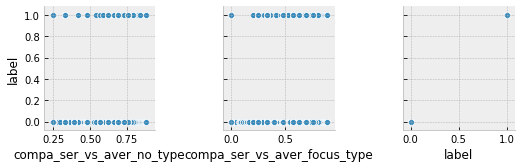

In [9]:
# plot feature-label relationships to see if theres any other pattern.
for i in range(0, len(no_outlier_trans.columns), 5):
    sns.pairplot(data=no_outlier_trans,
                x_vars=no_outlier_trans.columns[i:i+5],
                y_vars=['label'])

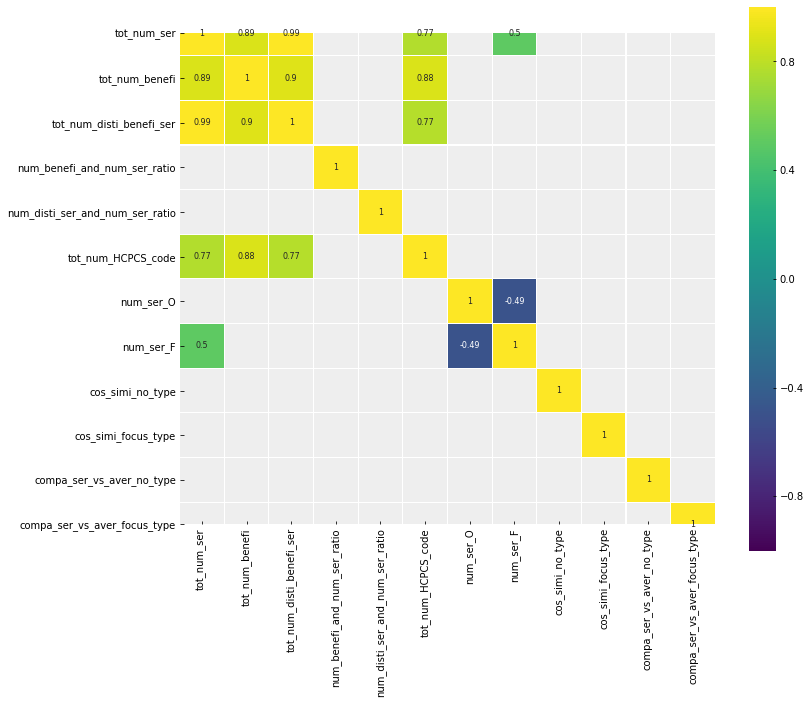

In [10]:
# plot pairwise correlations between features, very high / very low correlated feature can be removed since they don't provide additional info.
corr = no_outlier_trans.drop('label', axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [0]:
# plotting after sampling, to see if the feature distributions are still heavy tailed. 